In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np
from natsort import natsorted

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return natsorted(list(allsubs))

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.15], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

p = [np.stack([ts_to_flat_fc(ts) for ts in filter_design_ts(Xp)]) for Xp in X]
# Xfiltnorm = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(p[0].shape)

(830, 34716)


In [4]:
# Load big and small SNPs for all subjects with WRAT and RACE

from pathlib import Path
import numpy as np
import re

snpsdir = '../../ImageNomer/data/anton/cohorts/test/snps/'

big = dict()
small = dict()

for f in Path(snpsdir).iterdir():
    mobj = re.match('([0-9]+)_set-([a-z]+)_snps.npy', f.name)
    if not mobj:
        continue
    snps = np.load(f'{snpsdir}/{f.name}')
    subj = mobj.group(1)
    if mobj.group(2) == 'big':
        big[subj] = snps
    if mobj.group(2) == 'small':
        small[subj] = snps

print(len(list(big.keys())))
print(len(list(small.keys())))

927
927


In [5]:
# Get race info

# Get subjects from demographics file

import pickle

demofile = '../../ImageNomer/data/anton/cohorts/test/demographics.pkl'

with open(demofile, 'rb') as f:
    demo = pickle.load(f)
    
print(len(list(demo['race'].keys())))

830


In [69]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class LatSim(nn.Module):
    def __init__(self, dA, dB, ld=2):
        super(LatSim, self).__init__()
        self.A = nn.Parameter((torch.randn(dA,ld)/(dA**0.5)).float().cuda())
        self.B = nn.Parameter((torch.randn(dB,ld)/(dB**0.5)).float().cuda())

    def E(self, xtrA, xtrB, xtA, xtB):
#         for x in [xtrA, xtrB, xtA, xtB]:
#             print(x.shape)
#         raise 'bad'
        AT = (xtrA@self.A).T
        B = xtB@self.B
        BT = (xtrB@self.B).T
        A = xtA@self.A
        E1 = B@AT
        E2 = A@BT
        E1 = F.softmax(E1,dim=1)
        E2 = F.softmax(E2,dim=1)
        return 0.5*E1+0.5*E2
        
    def forward(self, xtrA, xtrB, ytr, xtA=None, xtB=None):
        if xtA is None:
            xtA = xtrA
            xtB = xtrB
        E = self.E(xtrA, xtrB, xtA, xtB)
        return E@ytr

def train_sim_mse(*args, **kwargs):
    kwargs['lossfn'] = nn.MSELoss()
    train_sim(*args, **kwargs)

def train_sim_ce(*args, **kwargs):
    kwargs['lossfn'] = nn.CrossEntropyLoss()
    train_sim(*args, **kwargs)

def train_sim(sim, xtrA, xtrB, ytr, stop, 
              lr=1e-4, nepochs=100, pperiod=20, lossfn=nn.MSELoss(), verbose=False):
    # Optimizers
    optim = torch.optim.Adam(sim.parameters(), lr=lr, weight_decay=0)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=20, factor=0.75, eps=1e-7)

    for epoch in range(nepochs):
        optim.zero_grad()
        idcs = torch.randperm(ytr.shape[0])
        idcs = idcs[:int(0.5*len(idcs))]
        yhat = sim(xtrA[idcs], xtrB[idcs], ytr[idcs])
        loss = lossfn(yhat, ytr[idcs])
        loss.backward()
        optim.step()
        if loss < stop:
            break
        sched.step(loss)
        if epoch % pperiod == 0 or epoch == nepochs-1:
            if verbose:
                print(f'{epoch} recon: {float(loss)} lr: {sched._last_lr}')

    optim.zero_grad()
    if verbose:
        print('Complete')
        
print('Done')

Done


In [71]:
fcs = []
snps = []
y = []

ntrain = 700

for sub in subs:
#     if demo['race'][str(sub)] == 'AA': 
    snps.append(small[str(sub)])
    y.append(metadict['wrat'][sub])
    fc = np.load(f'../../ImageNomer/data/anton/cohorts/test/fc/{sub}_task-rest_fc.npy')
    fcs.append(fc)

snps = np.stack(snps)
# x2 = snps
# x2[np.isnan(x2)] = 0
xa = snps == 0
xb = snps == 1
xc = snps == 2
x2 = np.concatenate([xa,xb,xc],axis=1)
x1 = np.stack(fcs)
y = np.stack(y)
print(x2.shape)
print(y.shape)
print(np.mean((y-np.mean(y))**2)**0.5)

rmses = []
ws = []
ref = []

for i in range(20):

    xx1 = torch.from_numpy(x1).float().cuda()
    xx2 = torch.from_numpy(x2).float().cuda()
    yy = torch.from_numpy(y).float().cuda()

    idcs = np.random.permutation(xx1.shape[0])
    xx1 = xx1[idcs]
    xxtr1 = xx1[:ntrain]
    xxt1 = xx1[ntrain:]

    xx2 = xx2[idcs]
    xxtr2 = xx2[:ntrain]
    xxt2 = xx2[ntrain:]

    mux = torch.mean(xxtr1, dim=0, keepdims=True)
    sigx = torch.std(xxtr1, dim=0, keepdims=True)
    xxtr1 = xxtr1 - mux
    xxt1 = xxt1 - mux
    
#     mux = torch.mean(xxtr2, dim=0, keepdims=True)
#     sigx = torch.std(xxtr2, dim=0, keepdims=True)
#     xxtr2 = xxtr2 - mux
#     xxt2 = xxt2 - mux
    
#     xx2 = xx1
#     xxtr2 = xxtr1
#     xxt2 = xxt1
    xx1 = xx2
    xxtr1 = xxtr2
    xxt1 = xxt2

    yy = yy[idcs]
    yytr = yy[:ntrain]
    yyt = yy[ntrain:]

    mu = torch.mean(yytr)
    yytr = yytr - mu
    yyt = yyt - mu

    sim = LatSim(xx1.shape[1], xx2.shape[1], ld=1)
    train_sim_mse(sim, xxtr1, xxtr2, yytr, stop=12*12)
    fake = torch.randperm(yytr.shape[0])
    yhat = sim(xxtr1, xxtr2, yytr, xxt1, xxt2)
    rmse = torch.mean((yhat-yyt)**2)**0.5
#     ws.append(sim.A.detach().cpu().numpy())
    ws.append(torch.einsum('ab,bc->b', xx1, sim.A).detach().cpu().numpy())
    ref.append(torch.mean(xx1, dim=0).detach().cpu().numpy())
    rmse = float(rmse)
    print(rmse)
    rmses.append(rmse)
    
print('----')
np.mean(rmses)

(830, 31299)
(830,)
15.861402953190794
13.539318084716797
15.210972785949707
14.338924407958984
13.413768768310547
13.85395622253418
14.214936256408691
12.985566139221191
13.611953735351562
15.064480781555176
14.58092212677002
14.269187927246094
14.08095932006836
15.557987213134766
16.961669921875
13.952715873718262
16.95806312561035
15.103429794311523
13.506558418273926
14.359231948852539
16.562055587768555
----


14.606332921981812

In [59]:
import matplotlib.pyplot as plt

E = sim.E(xxtr1, xxtr2, xxt1, xxt2)
E = E.detach().cpu().numpy()

print(np.sum(E[1]))
print(np.sum(E[10]))

AT = (xxtr1@sim.A).T
B = xxt2@sim.B
BT = (xxtr2@sim.B).T
A = xxt1@sim.A

E2 = B@AT
E2 = F.softmax(E2, dim=1)
print(E2[3])

# print(E2.shape)

# plt.imshow(E2.detach().cpu().numpy())
# plt.show()

1.0
1.0
tensor([0.0010, 0.0015, 0.0016, 0.0014, 0.0011, 0.0009, 0.0030, 0.0005, 0.0008,
        0.0008, 0.0004, 0.0014, 0.0017, 0.0029, 0.0016, 0.0009, 0.0024, 0.0009,
        0.0024, 0.0061, 0.0008, 0.0011, 0.0012, 0.0005, 0.0006, 0.0007, 0.0020,
        0.0003, 0.0019, 0.0011, 0.0008, 0.0007, 0.0008, 0.0012, 0.0017, 0.0009,
        0.0005, 0.0009, 0.0013, 0.0008, 0.0009, 0.0007, 0.0010, 0.0015, 0.0025,
        0.0015, 0.0007, 0.0006, 0.0013, 0.0011, 0.0029, 0.0008, 0.0004, 0.0008,
        0.0008, 0.0011, 0.0015, 0.0009, 0.0020, 0.0010, 0.0009, 0.0034, 0.0012,
        0.0008, 0.0005, 0.0015, 0.0009, 0.0010, 0.0009, 0.0014, 0.0023, 0.0025,
        0.0014, 0.0005, 0.0007, 0.0006, 0.0008, 0.0014, 0.0005, 0.0006, 0.0007,
        0.0021, 0.0004, 0.0024, 0.0004, 0.0009, 0.0016, 0.0042, 0.0007, 0.0006,
        0.0047, 0.0026, 0.0005, 0.0013, 0.0007, 0.0009, 0.0003, 0.0015, 0.0008,
        0.0023, 0.0004, 0.0009, 0.0006, 0.0031, 0.0006, 0.0023, 0.0011, 0.0005,
        0.0021, 0.0054, 0.0051, 

In [22]:
E@yytr.detach().cpu().numpy()

array([ 6.03894043e+01, -2.66905708e+01, -3.96099930e+01, -3.23165283e+01,
        8.80734634e+00,  3.49542313e+01,  6.13452435e-01,  3.43218842e+01,
        2.62610455e+01, -6.04596176e+01, -6.17654572e+01, -2.09672375e+01,
        1.00361481e+01,  2.89798832e+00, -5.89407692e+01, -2.49347992e+01,
        4.22417374e+01, -2.52126789e+00, -1.32490177e+01, -4.89786911e+00,
       -1.69282608e+01, -2.31743927e+01, -2.22241664e+00, -3.46114135e+00,
        4.99215355e+01,  2.67177734e+01,  1.19668901e-01, -5.76645355e+01,
        1.96663742e+01,  1.96748848e+01,  1.09840078e+01, -6.77954769e+00,
       -3.35089636e+00, -4.81016464e+01, -8.00877690e-01,  3.89731369e+01,
        1.14079058e+00, -6.74114323e+00, -3.25049858e+01, -5.98090506e+00,
       -2.48569202e+01, -2.90688553e+01,  9.10344601e+00,  3.88939705e+01,
        3.12793865e+01,  1.54670887e+01, -3.31318998e+00,  2.06807499e+01,
        2.20437355e+01,  7.79600954e+00,  3.24092979e+01, -6.63810272e+01,
       -3.85914254e+00,  

In [313]:
mu

tensor(180.9786, device='cuda:0')

/tmp/ipykernel_2147/3573602998.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


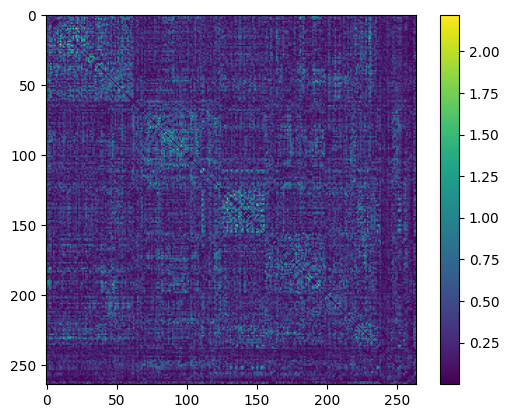

In [226]:
import matplotlib.pyplot as plt

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,  
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

def vec2mat(x):
    a,b = np.triu_indices(264,1)
    xx = np.zeros((264,264))
    xx[a,b] = x
    return xx+xx.T

A = vec2mat(np.mean(ws2, axis=0).reshape(-1))
A = A+np.mean(A)*np.eye(264)
A[np.abs(A) < 0.000] = 0

r = vec2mat(np.mean(ref, axis=0))

fig, ax = plt.subplots()
im = ax.imshow(remap(np.abs(A)))
fig.colorbar(mappable=im, ax=ax)
# im = ax[1].imshow(remap(r))
# fig.colorbar(mappable=im, ax=ax[1])
fig.show()

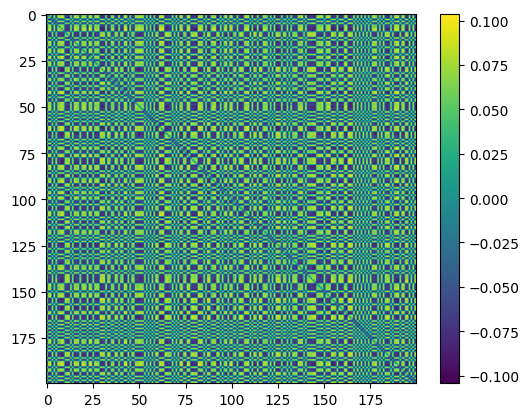

In [224]:
c = np.corrcoef(np.stack(ws).reshape(200,-1))
c = c - np.eye(200)
plt.imshow(c)
plt.colorbar()
plt.show()

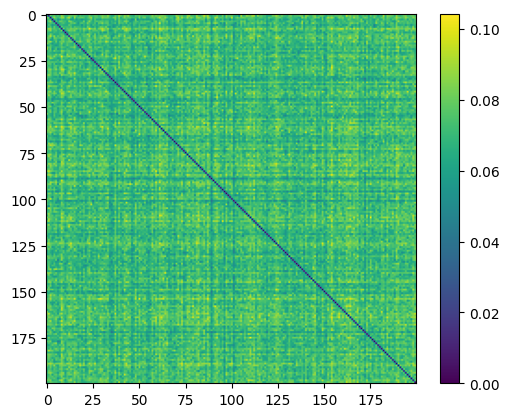

In [225]:
ws2 = []

for i in range(200):
    if c[0,i] < -0.01:
        ws2.append(-ws[i])
    else:
        ws2.append(ws[i])
        
d = np.corrcoef(np.stack(ws2).reshape(200,-1))
d = d - np.eye(200)
plt.imshow(d)
plt.colorbar()
plt.show()